# Random Forest Classifier
### Importing data:

In [1]:
import pandas as pd
from numpy import nan
import numpy as np
import scipy.stats as stats
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
violations = pd.read_pickle('data/violations.pkl')

In [3]:
violations = violations[violations.delay > 21]
X = violations.drop(['date','restaurant_id','*','**','***','name','reviews','rating','delay'],1)
y = (violations['*'] + violations['**'] + violations['***'] > 0).values.astype(np.int)

### Cross-validated hyperparameter tuning:

In [4]:
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=.8, stratify = y)
gs = GridSearchCV(
        estimator = RandomForestClassifier(n_estimators = 1000),
        param_grid = {
            'min_samples_leaf' : np.arange(1, 6, 1),
            'max_features' : np.arange(1, 12, 1)
        },
        n_jobs = -1
)
gs.fit(Xtrain, ytrain)
clf = gs.best_estimator_
gs.best_params_

{'max_features': 5, 'min_samples_leaf': 3}

### Evaluation:
* Accuracies on training and test sets
* ROC curve and its AUC
* Precision-recall curve and its AUC
* Learning curve

In [5]:
clf.score(Xtrain, ytrain), clf.score(Xtest, ytest)

(0.9197202797202797, 0.86465324384787468)

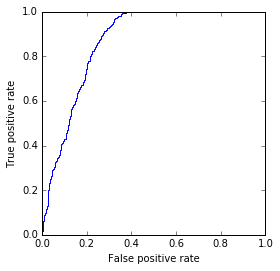

0.8689787740957331

In [6]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
plt.rcParams['figure.figsize'] = (4, 4)
xroc, yroc, _ = roc_curve(ytest, clf.predict_proba(Xtest)[:,1])
plt.plot(xroc, yroc)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()
auc(xroc,yroc)

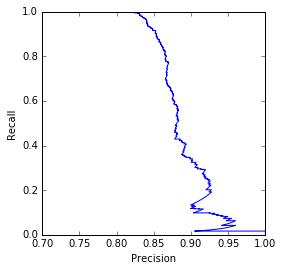

0.88858185318827121

In [7]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
xprc, yprc, _ = precision_recall_curve(ytest, clf.predict_proba(Xtest)[:,1])
plt.plot(xprc, yprc)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.show()
average_precision_score(ytest, clf.predict_proba(Xtest)[:,1])

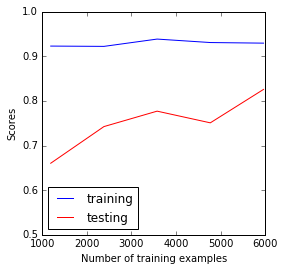

In [8]:
from sklearn.learning_curve import learning_curve
train_size, train_score, test_score = learning_curve(
    clf, 
    X, 
    y, 
    n_jobs = -1,
    train_sizes = (.2, .4, .6, .8, 1.0)
)
plt.plot(
    train_size, 
    train_score.mean(axis = 1), 
    label='training'
)
plt.plot(
    train_size, 
    test_score.mean(axis = 1), 
    label='testing', c='red'
)
plt.legend(loc = 0)
plt.ylim([0.5,1])
plt.xlabel('Number of training examples')
plt.ylabel('Scores')
plt.show()

### List of feature importances, and a new classifier using only the most important 10 features:

In [9]:
featurelist = pd.DataFrame()
featurelist['name'] = X.columns
featurelist['importance'] = clf.feature_importances_
featurelist.sort_values('importance', ascending = False)

,name,importance
48,day,0.161620
47,month,0.138974
49,weekday,0.107291
11,Trees,0.041794
8,Recycling,0.037926
3,Highway Maintenance,0.034894
4,Street Cleaning,0.028303
0,latitude,0.025559
7,Housing,0.023653
1,longitude,0.022743


In [10]:
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X[featurelist.sort_values('importance', ascending = False).head(10).name], 
    y, train_size=.8, stratify = y
)

gs = GridSearchCV(
        estimator = RandomForestClassifier(n_estimators = 1000),
        param_grid = {
            'min_samples_leaf' : np.arange(1, 6, 1),
            'max_features' : np.arange(1, 6, 1)
        },
        n_jobs = -1
)
gs.fit(Xtrain, ytrain)
clf = gs.best_estimator_
gs.best_params_

{'max_features': 4, 'min_samples_leaf': 3}

In [11]:
clf.score(Xtrain, ytrain), clf.score(Xtest, ytest)

(0.93944055944055949, 0.86129753914988816)